# Load data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import random

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer, Dense, Embedding, Dropout


RANDOM_SEED = 1
tf.random.set_seed(RANDOM_SEED)

In [2]:
def text_normalize(text):
    text = text.lower()
    text = text.strip() 
    text = re.sub(r'[^\w\s\n]', '', text)
    text = text.replace('\n\n', '\n')
    text = '\n'.join(['<start> ' + line + ' <end>' for line in text.split('\n') if line != '' and len(line.split()) == 5])
 
    return text

In [3]:
BATCH_SIZE = 32
MAX_SEQ_LEN = 7
VOCAB_SIZE = 5000

In [4]:
DATASET_PATH = 'data-set1.csv'

df = pd.read_csv(DATASET_PATH, index_col=0)
df['poem_content'] = df['poem_content'].apply(lambda p: text_normalize(p))
# df['poem_content'] = df['poem_content'].astype(str).apply(lambda p: text_normalize(p))
corpus = df['poem_content'].to_numpy()

X = []
y = []
for idx, row in df.iterrows():
    lines = row['poem_content'].split('\n')
    lines = [line for line in lines if line != '']
    for idx in range(0, len(lines) - 1):
        input_sentence = lines[idx]
        output_sentence = lines[idx+1]

        X.append(input_sentence)
        y.append(output_sentence)

In [5]:
for idx in range(len(X))[:10]:
    print(f'Input: {X[idx]} => {y[idx]}')

Input: <start> hầu hết các đồ vật <end> => <start> ta muốn đều đắt tiền <end>
Input: <start> ta muốn đều đắt tiền <end> => <start> một khi không có được <end>
Input: <start> một khi không có được <end> => <start> ta cảm thấy buồn phiền <end>
Input: <start> ta cảm thấy buồn phiền <end> => <start> trong khi cái thực sự <end>
Input: <start> trong khi cái thực sự <end> => <start> làm ta vui ở đời <end>
Input: <start> làm ta vui ở đời <end> => <start> hoàn toàn không tốn kém <end>
Input: <start> hoàn toàn không tốn kém <end> => <start> là tình yêu tiếng cười <end>
Input: <start> hiện tại anh đang sống <end> => <start> không được để phí hoài <end>
Input: <start> không được để phí hoài <end> => <start> vì nỗi buồn quá khứ <end>
Input: <start> vì nỗi buồn quá khứ <end> => <start> và sợ hãi tương lai <end>


In [6]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='', oov_token="<OOV>")
tokenizer.fit_on_texts(corpus)

VOCAB_SIZE = len(tokenizer.word_index) + 1

In [7]:
def prepare_output_sequences(y_sequences):
    y_inputs = pad_sequences([y_seq[:-1] for y_seq in y_sequences], maxlen=MAX_SEQ_LEN, truncating='pre', padding='post')
    y_outputs = pad_sequences([y_seq[1:] for y_seq in y_sequences], maxlen=MAX_SEQ_LEN, truncating='pre', padding='post')

    return y_inputs, y_outputs

X_sequences = tokenizer.texts_to_sequences(X)
X_padded_sequences = pad_sequences(X_sequences, maxlen=MAX_SEQ_LEN, truncating='pre', padding='post')

y_sequences = tokenizer.texts_to_sequences(y)
y_inputs, y_outputs = prepare_output_sequences(y_sequences)

In [8]:
n_samples = len(X_padded_sequences)
train_len = int(n_samples * 0.7)
val_len = int(n_samples * 0.2)
test_len = n_samples - train_len - val_len

# Shuffle 
np.random.seed(1)
idxs = np.arange(n_samples)
idxs = np.random.permutation(idxs)

X_padded_sequences = X_padded_sequences[idxs]
y_inputs = y_inputs[idxs]
y_outputs = y_outputs[idxs]

# Split the data into train, validation, and test sets
X_train_seq, y_train_input, y_train_output = X_padded_sequences[:train_len], y_inputs[:train_len], y_outputs[:train_len]
X_val_seq, y_val_input, y_val_output = X_padded_sequences[train_len:train_len+val_len], y_inputs[train_len:train_len+val_len], y_outputs[train_len:train_len+val_len]
X_test_seq, y_test_input, y_test_output = X_padded_sequences[train_len+val_len:], y_inputs[train_len+val_len:], y_outputs[train_len+val_len:]

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices(((X_train_seq, y_train_input), y_train_output)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices(((X_val_seq, y_val_input), y_val_output)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices(((X_test_seq, y_test_input), y_test_output)).batch(BATCH_SIZE)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for i, j in train_ds:
    print(j)
    print(i)

## Nháp

In [82]:
maxlen = 5
vocab_size = VOCAB_SIZE = 5000


vectorize_layer = tf.keras.layers.TextVectorization(
    # standardize=text_normalize,
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=maxlen,
)
vectorize_layer.adapt(corpus)
vectorized_sequences = vectorize_layer(X)
print(vectorized_sequences)
vectorized_sequences = vectorize_layer(X)
print(vectorized_sequences)

tf.Tensor(
[[  2 257  85 282 178]
 [  2   6  45 179 181]
 [  2   5   7  13  10]
 ...
 [  2 126 114  27 241]
 [  2   1 364  60 248]
 [  2 351   1   1   1]], shape=(776, 5), dtype=int64)
tf.Tensor(
[[  2 257  85 282 178]
 [  2   6  45 179 181]
 [  2   5   7  13  10]
 ...
 [  2 126 114  27 241]
 [  2   1 364  60 248]
 [  2 351   1   1   1]], shape=(776, 5), dtype=int64)


In [83]:
START_TOKEN = 101
END_TOKEN = 102

# Thêm các token đặc biệt vào đầu và cuối mỗi chuỗi
sequences_with_special_tokens = [
    [START_TOKEN] + seq + [END_TOKEN]
    for seq in vectorized_sequences
]

# Thêm padding vào dữ liệu token
padded_sequences = pad_sequences(sequences_with_special_tokens, padding='post', value=0)

print(padded_sequences)


[[205 460 288 485 381]
 [205 209 248 382 384]
 [205 208 210 216 213]
 ...
 [205 329 317 230 444]
 [205 204 567 263 451]
 [205 554 204 204 204]]


# Model

## Learned Positional Encoding

In [107]:
class LearnedPositionalEmbedding(Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.token_embedding = Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_embedding = Embedding(vocab_size, d_model, mask_zero=True)
    
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        x = self.token_embedding(x)
        pos = self.pos_embedding(positions)
        x = x + pos
        return x 



#### Nháp

In [10]:
token_embedding = Embedding(200, 5, mask_zero=True)
pos_embedding = Embedding(4, 5, mask_zero=True)



arr = np.array([[2, 43, 64, 2, 0], [2, 43, 64, 2, 0]])
arr = tf.convert_to_tensor(arr)
len = tf.shape(arr)[-1]
# positions = tf.range(start=0, limit=len, delta=1)
# pos_embedding(positions)

In [109]:
layer = LearnedPositionalEmbedding(100, 4)
layer(arr.numpy())

<tf.Tensor: shape=(2, 5, 4), dtype=float32, numpy=
array([[[ 0.03791033,  0.07307654,  0.00085772, -0.04303437],
        [-0.03054502,  0.01317374,  0.02801207,  0.0688414 ],
        [ 0.0350856 , -0.01020268, -0.03094573,  0.08283221],
        [ 0.05233429,  0.01663573, -0.01136755,  0.03040729],
        [ 0.00346883,  0.04577436, -0.01387558, -0.06228261]],

       [[ 0.03791033,  0.07307654,  0.00085772, -0.04303437],
        [-0.03054502,  0.01317374,  0.02801207,  0.0688414 ],
        [ 0.0350856 , -0.01020268, -0.03094573,  0.08283221],
        [ 0.05233429,  0.01663573, -0.01136755,  0.03040729],
        [ 0.00346883,  0.04577436, -0.01387558, -0.06228261]]],
      dtype=float32)>

## Sinusoidal Positional Encoding

In [11]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

class SinusoidalPositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

#### Nháp

In [138]:
l = SinusoidalPositionalEmbedding(100, 4)
arr = np.array([[2, 43, 64, 2, 0], [2, 43, 64, 2, 0]])
arr = tf.convert_to_tensor(arr)
l(arr)

<tf.Tensor: shape=(2, 5, 4), dtype=float32, numpy=
array([[[ 0.01439571, -0.02052017,  1.0712036 ,  1.0666127 ],
        [ 0.9209103 , -0.07773701,  0.5385275 ,  1.0080634 ],
        [ 0.82433563,  0.05706312, -0.5143424 ,  1.0509923 ],
        [ 0.15551572,  0.00947534, -0.9187889 ,  1.0661628 ],
        [-0.79392606,  0.0784515 , -0.65642554,  1.0120287 ]],

       [[ 0.01439571, -0.02052017,  1.0712036 ,  1.0666127 ],
        [ 0.9209103 , -0.07773701,  0.5385275 ,  1.0080634 ],
        [ 0.82433563,  0.05706312, -0.5143424 ,  1.0509923 ],
        [ 0.15551572,  0.00947534, -0.9187889 ,  1.0661628 ],
        [-0.79392606,  0.0784515 , -0.65642554,  1.0120287 ]]],
      dtype=float32)>

## Base Self-attention Layer

In [12]:
class BaseAttention(Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.multihead = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

## Cross-attention Layer

In [13]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        out_put, scores = self.multihead(
            query=x,
            value=context,
            key=context,
            return_attention_scores=True)
        
        self.attention_scores = scores
        
        x = self.add([x, out_put])
        return self.layernorm(x)


#### Nháp

In [126]:
# Create an instance of CrossAttention
test_scores = CrossAttention(
    num_heads=2,        
    key_dim=4 // 2,     
    value_dim=4 // 2,  
)

# Call the call method to compute attention and store the scores
output = test_scores(v, v) 

# Access the attention_scores from the instance
scores = test_scores.attention_scores 

print(scores)

tf.Tensor(
[[[[0.21232034 0.18255974 0.21485221 0.1788626  0.21140505]
   [0.073286   0.14252862 0.3329414  0.11701349 0.3342305 ]
   [0.23401469 0.22498412 0.14746809 0.24371831 0.14981481]
   [0.36998218 0.1875155  0.11549442 0.21384495 0.11316297]
   [0.20887628 0.2212073  0.1677036  0.23190716 0.17030561]]

  [[0.17774892 0.31501913 0.1490758  0.10378786 0.25436828]
   [0.2447398  0.1718101  0.13147347 0.27369794 0.17827867]
   [0.24135087 0.10497415 0.12549293 0.40093675 0.12724534]
   [0.16262043 0.28726637 0.19932269 0.10679477 0.24399574]
   [0.21678881 0.12738472 0.18353868 0.32344913 0.1488387 ]]]], shape=(1, 2, 5, 5), dtype=float32)


## Causal Self-attention Layer

In [14]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):   
        attention = self.multihead(
            query=x,
            value=x,
            key=x,
            use_causal_mask=True
        ) 
        out_put = self.add([attention, x])
        return self.layernorm(out_put)

#### Nháp

In [116]:
# def create_causal_mask(size):
#   """Tạo causal mask cho self-attention."""
#   mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
#   return mask  * -1e9 


# attention_scores = ... 
# mask = create_causal_mask(tf.shape(attention_scores)[1])
# masked_attention_scores = attention_scores + mask
# attention_probs = tf.nn.softmax(masked_attention_scores)

In [127]:
v = tf.convert_to_tensor(tf.random.normal((1, 5, 4)))
print(v)

tf.Tensor(
[[[-0.45701224 -0.40686727  0.7285778  -0.8929778 ]
  [ 0.31261146  0.9942925  -1.7842623  -0.52200514]
  [ 0.98080045 -0.67598516  1.1456147   0.20607261]
  [-0.19721638  0.53809345  0.7643299  -0.8361918 ]
  [ 0.3361417   1.5602019   0.7227835   1.0754888 ]]], shape=(1, 5, 4), dtype=float32)


In [128]:

attention_layer = CausalSelfAttention(
    num_heads=2,      
    key_dim=4 // 2,  
    value_dim=4 // 2, 
)
l = attention_layer(v)
print(l)


tf.Tensor(
[[[-0.50193805  0.27502665  1.4622862  -1.2353748 ]
  [ 0.7758726   0.88109475 -1.6174264  -0.03954103]
  [ 0.6116012  -1.637973    0.96565014  0.06072188]
  [-0.5460929   0.67577624  1.205087   -1.3347702 ]
  [-1.3937474   1.3079363  -0.36008006  0.44589058]]], shape=(1, 5, 4), dtype=float32)


## Global Self-attention Layer

In [15]:
class GlobalSelfAttention(BaseAttention):
    def call(self, context):   
        attention = self.multihead(
            query=context,
            value=context,
            key=context
        ) 
        out_put = self.add([attention, context])
        return self.layernorm(out_put)


## Feed-forward Network

In [16]:
class Feedforward(Layer):
    def __init__(self, ff_dim, d_model, drop_rate=0.1):
        super().__init__()
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(d_model), Dropout(drop_rate)]
        )
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()
    
    def call(self, input):
        out_put = self.add([self.ffn(input), input])
        return self.layernorm(out_put)


## Encoder Layer

In [17]:
class EncoderLayer(Layer):
    def __init__(self, *, num_heads, ff_dim, d_model, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate
        )
        self.feedforward = Feedforward(ff_dim, d_model)

    def call(self, context):
        context = self.self_attention(context)
        out_put = self.feedforward(context)
        return out_put
    

## Transformer Encoder

In [18]:
class Encoder(Layer):
    """Đây là một mô tả ngắn gọn về lớp Decoder.

    Args:
        num_heads (int): Số lớp self head attention.
        vocab_size (int): Kích thước của vocabulary thường là rất lớn.
        num_layers (int): Số lượng lớp block encoder recomment = 6.
        ff_dim (int): Kích thước lớp dense của feed forward layer.
        d_model (int): Chiều sâu mô hình recomment = 128/258/512/1024.
        dropout_rate (float): Tỉ lệ drop out. Mặc định là '0.1'.


    """
    def __init__(self, *, num_heads, vocab_size, num_layers, ff_dim, d_model, dropout_rate=0.1):
        super().__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding =  SinusoidalPositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.N_layers = [EncoderLayer(
                        num_heads=num_heads,
                        ff_dim=ff_dim,
                        d_model=d_model,
                        dropout_rate=dropout_rate,) 
                        for _ in range(num_layers)]
        self.drop_out = Dropout(dropout_rate)

    def call(self, context):
        context = self.pos_embedding(context)
        context = self.drop_out(context)

        for i in range(self.num_layers):
            context = self.N_layers[i](context)
        return context


#### Nháp

In [29]:
v = tf.convert_to_tensor(tf.random.normal((1, 5, 4)))
print(v)
layr = Decoder(num_heads=1, vocab_size=1000, num_layers=1, ff_dim=10, d_model=4)
print(v)
layr(v, v)


tf.Tensor(
[[[-1.1771784  -0.90325946  0.8419609  -0.06870949]
  [-0.96161884 -0.51533026  2.4461458   1.3048527 ]
  [-2.2004392   0.60459185 -0.5646027   0.10282746]
  [-0.827649    0.48992977  0.72180253 -1.3863678 ]
  [ 0.8310243   0.27414545 -0.42633235  0.49712068]]], shape=(1, 5, 4), dtype=float32)
tf.Tensor(
[[[-1.1771784  -0.90325946  0.8419609  -0.06870949]
  [-0.96161884 -0.51533026  2.4461458   1.3048527 ]
  [-2.2004392   0.60459185 -0.5646027   0.10282746]
  [-0.827649    0.48992977  0.72180253 -1.3863678 ]
  [ 0.8310243   0.27414545 -0.42633235  0.49712068]]], shape=(1, 5, 4), dtype=float32)


InvalidArgumentError: Exception encountered when calling layer "sinusoidal_positional_embedding_8" "                 f"(type SinusoidalPositionalEmbedding).

{{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} required broadcastable shapes [Op:AddV2]

Call arguments received by layer "sinusoidal_positional_embedding_8" "                 f"(type SinusoidalPositionalEmbedding):
  • x=tf.Tensor(shape=(1, 5, 4), dtype=float32)

<!-- ## Decoder Layer -->

In [26]:
class DecoderLayer(Layer):
    def __init__(self, *,num_heads, d_model, ff_dim, dropout_rate=0.1):
        super().__init__()

        self.mask_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate,)
        
        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate,)
        self.feed_forward = Feedforward(ff_dim, d_model)

    def call(self, x, context):
        x = self.mask_self_attention(x=x)
        out_put1 = self.cross_attention(x, context=context)

        # Cache the last attention scores for plotting later
        self.attention_scores = self.cross_attention.attention_scores
        out_put2 = self.feed_forward(out_put1)

        return out_put2 # Shape (batch_size, seq_len, d_model)

## Transformer Decoder

In [27]:
class Decoder(Layer):
    """Đây là một mô tả ngắn gọn về lớp Decoder.

    Args:
        num_heads (int): Số lớp self head attention.
        vocab_size (int): Kích thước của vocabulary thường là rất lớn.
        num_layers (int): Số lượng lớp block decoder recomment = 6.
        ff_dim (int): Kích thước lớp dense của feed forward layer.
        d_model (int): Chiều sâu mô hình recomment = 128/258/512/1024.
        dropout_rate (float): Tỉ lệ drop out. Mặc định là '0.1'.


    """

    def __init__(self, *, num_heads, vocab_size, num_layers, ff_dim, d_model, dropout_rate=0.1):
        super().__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding =  SinusoidalPositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
        self.N_layers = [
            DecoderLayer(num_heads=num_heads,
                        ff_dim=ff_dim,
                        d_model=d_model,
                        dropout_rate=dropout_rate,) 
            for _ in range(num_layers)]
        self.drop_out = Dropout(dropout_rate)

        self.attention_scores = None

    def call(self, x, context):
        x = self.pos_embedding(x)
        x = self.drop_out(x)

        for i in range(self.num_layers):
            y = self.N_layers[i](x, context)

        self.attention_scores = self.N_layers[-1].attention_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return y


## Transformer Model

In [25]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, ff_dim,
                vocab_size, dropout_rate=0.1):
        super().__init__()

        self.encoder = Encoder(num_heads=num_heads,
                               d_model=d_model,
                               vocab_size=vocab_size,
                               ff_dim=ff_dim,
                               num_layers=num_layers,
                               dropout_rate=dropout_rate,)
        
        self.decoder = Decoder(num_heads=num_heads,
                               d_model=d_model,
                               vocab_size=vocab_size,
                               ff_dim=ff_dim,
                               num_layers=num_layers,
                               dropout_rate=dropout_rate,)
        
        self.final_layer = Dense(vocab_size)
        
    def call(self, inputs):
        context, x  = inputs

        context = self.encoder(context)
        x = self.decoder(x, context)
    
        logits = self.final_layer(x)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

In [64]:
N_LAYERS = 4
D_MODEL = 128
D_FF = 512
N_HEADS = 8
DROPOUT_RATE = 0.2
transformer = Transformer(
    num_layers=N_LAYERS,
    d_model=D_MODEL,
    num_heads=N_HEADS,
    ff_dim=D_FF,
    vocab_size=VOCAB_SIZE,
    dropout_rate=DROPOUT_RATE
)

In [65]:
batches = train_ds.take(2)
for batch in batches:
    X_try, y_try = batch[0], batch[1]
    break

In [66]:
output = transformer(X_try)
output.shape


TensorShape([32, 7, 5000])

In [67]:
transformer.summary()

Model: "transformer_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_2 (Encoder)         multiple                  3278848   
                                                                 
 decoder_2 (Decoder)         multiple                  5389824   
                                                                 
 dense_50 (Dense)            multiple                  645000    
                                                                 
Total params: 9,313,672
Trainable params: 9,313,672
Non-trainable params: 0
_________________________________________________________________


In [30]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [68]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, 
    beta_1=0.9, 
    beta_2=0.98,
    epsilon=1e-9
)

In [32]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)

    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

def compute_perplexity(logits, targets):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

    loss = loss_fn(targets, logits)

    perplexity = np.exp(np.mean(loss))

    return perplexity


def compute_bleu(predicted, targets):
    predicted_strings = []
    for seq in predicted:
        seq = np.argmax(seq, axis=1)
        string_seq = " ".join([tokenizer.sequences_to_texts([[token]])[0] for token in seq if token != 0])
        predicted_strings.append(string_seq)
    target_strings = []
    for seq in targets:
        seq = seq.numpy().tolist()
        string_seq = " ".join([tokenizer.sequences_to_texts([[token]])[0] for token in seq if token != 0])
        target_strings.append([string_seq])  

    bleu_score = corpus_bleu(target_strings, predicted_strings)

    return bleu_score

In [69]:
# Khai báo một số giá trị siêu tham số
EPOCHS = 30


In [70]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy]
)

In [71]:
history = transformer.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds
)

Epoch 1/30
17/17 [==============================] - 11s 189ms/step - loss: 8.5375 - masked_accuracy: 0.0000e+00 - val_loss: 8.5330 - val_masked_accuracy: 0.0000e+00
Epoch 2/30
17/17 [==============================] - 1s 35ms/step - loss: 8.5029 - masked_accuracy: 0.0000e+00 - val_loss: 8.4736 - val_masked_accuracy: 0.0021
Epoch 3/30
17/17 [==============================] - 1s 35ms/step - loss: 8.4314 - masked_accuracy: 0.0071 - val_loss: 8.3804 - val_masked_accuracy: 0.0625
Epoch 4/30
17/17 [==============================] - 1s 36ms/step - loss: 8.3293 - masked_accuracy: 0.1192 - val_loss: 8.2662 - val_masked_accuracy: 0.1667
Epoch 5/30
17/17 [==============================] - 1s 38ms/step - loss: 8.2090 - masked_accuracy: 0.1667 - val_loss: 8.1474 - val_masked_accuracy: 0.1667
Epoch 6/30
17/17 [==============================] - 1s 35ms/step - loss: 8.0852 - masked_accuracy: 0.1667 - val_loss: 8.0348 - val_masked_accuracy: 0.1667
Epoch 7/30
17/17 [==============================] - 1s 3

In [55]:
# Đánh giá mô hình trên tập test
test_evaluation = transformer.evaluate(test_ds)

3/3 [==============================] - 0s 44ms/step - loss: 5.7151 - masked_accuracy: 0.1667


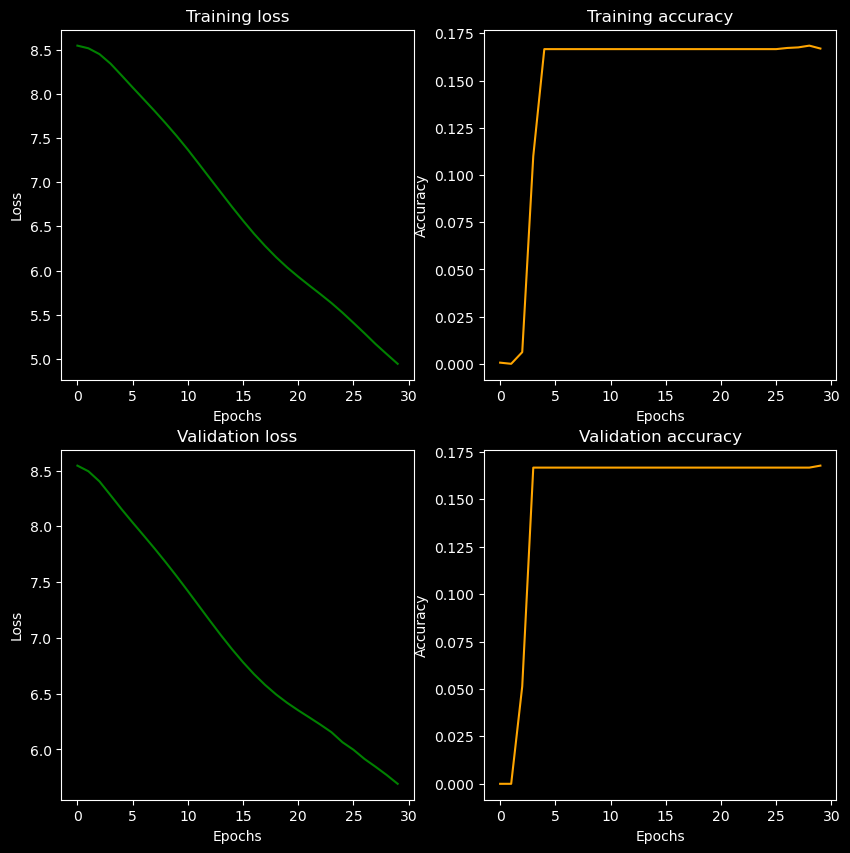

In [56]:

# Đọc các kết quả huấn luyện mô hình qua từng epoch
train_loss, train_acc = history.history['loss'], history.history['masked_accuracy'] # Đọc thông tin loss, acc trên tập train
val_loss, val_acc = history.history['val_loss'], history.history['val_masked_accuracy'] # Đọc thông tin loss, acc trên tập val

plt.figure(figsize=(10, 10)) # Cài đặt kích thước khung ảnh

plt.subplot(2, 2, 1) # Khởi tạo khung ảnh cho training loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Training loss') # Hiển thị title của khung ảnh hiện tại là 'Training Loss'
plt.plot(train_loss, color='green') # Vẽ đường giá trị loss trên tập train qua từng epoch (đường vẽ màu đỏ)

plt.subplot(2, 2, 2) # Khởi tạo khung ảnh cho training acc
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Accuracy') # Hiển thị tên trục tung là 'Accuracy'
plt.title('Training accuracy') # Hiển thị title của khung ảnh hiện tại là 'Training accuracy'
plt.plot(train_acc, color='orange') # Vẽ đường giá trị accuracy trên tập train qua từng epoch (đường vẽ màu cam)

plt.subplot(2, 2, 3) # Khởi tạo khung ảnh cho val loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Validation loss') # Hiển thị title của khung ảnh hiện tại là 'Validation loss'
plt.plot(val_loss, color='green') # Vẽ đường giá trị loss trên tập val qua từng epoch (đường vẽ màu đỏ)

plt.subplot(2, 2, 4) # Khởi tạo khung ảnh cho val acc
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Accuracy') # Hiển thị tên trục tung là 'Accuracy'
plt.title('Validation accuracy') # Hiển thị title của khung ảnh hiện tại là 'Validation accuracy'
plt.plot(val_acc, color='orange') # Vẽ đường giá trị accuracy trên tập val qua từng epoch (đường vẽ màu cam)

plt.show() # Hiển thị 4 khung ảnh nhỏ

In [57]:
def generate_text(
    generator_model, 
    tokenizer,
    input_string
    ):
    
    encoder_input_string = text_normalize(input_string) 
    encoder_input_sequence = tokenizer.texts_to_sequences([encoder_input_string])
    encoder_input_padded_sequence = pad_sequences(encoder_input_sequence, maxlen=MAX_SEQ_LEN, truncating='pre', padding='post')[0]
    encoder_input_padded_sequence = np.expand_dims(encoder_input_padded_sequence, axis=0)

    decoder_input_string = '<start>'
    decoder_input_sequence = tokenizer.texts_to_sequences([decoder_input_string])
    decoder_input_padded_sequence = pad_sequences(decoder_input_sequence, maxlen=MAX_SEQ_LEN, truncating='pre', padding='post')[0]
    start = decoder_input_padded_sequence[0][tf.newaxis]
    end = decoder_input_padded_sequence[1][tf.newaxis]
    decoder_input_padded_sequence = np.expand_dims(decoder_input_padded_sequence, axis=0)

    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(MAX_SEQ_LEN):
        output = tf.transpose(output_array.stack())
        predictions = generator_model((encoder_input_padded_sequence, output), training=False)

        # Select the last token from the `seq_len` dimension.
        predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

        predicted_id = tf.argmax(predictions, axis=-1)

        # Concatenate the `predicted_id` to the output which is given to the
        # decoder as its input.
        output_array = output_array.write(i+1, predicted_id[0])

        if predicted_id == end:
            break

    output = tf.transpose(output_array.stack())
    output_tokens = output.numpy()
    # The output shape is `(1, tokens)`.
    text = tokenizer.sequences_to_texts(output_tokens)[0]  # Shape: `()`.


    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    generator_model([decoder_input_padded_sequence, output[:, :-1]], training=False)
    attention_weights = generator_model.decoder.attention_scores

    return text, output_tokens, attention_weights

In [59]:
n_sentences = 2
results = ['em đi anh lạc đường']
for idx in range(n_sentences + 1):
    input_str = results[idx]
    text, output_tokens, attention_weights = generate_text(
        transformer, 
        tokenizer,
        input_str
    )
    results.append(text.replace('<start>', '').replace('<end>', ''))

print('\n'.join(results))

em đi anh lạc đường
       
       
       
